# Introduction to Neural Networks with PyTorch
Let us start by importing the necessary modules.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from time import time as clock
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Going to use", device)

Going to use cpu


## Define the Neural Network's Structure
Define a network with ELU activation functions (a smooth approximation of ReLU) and with:
* 1 input layer
* 2 hidden layer2
* 1 output layer

In [2]:
class SimpleNetwork(nn.Module):

    def __init__(self, n_inputs, n_outputs, n_hidden=16):
        super(SimpleNetwork, self).__init__()
        self.layer1 = nn.Linear(n_inputs, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer3 = nn.Linear(n_hidden, n_outputs)

    # Called with either one element to determine next output, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.elu(self.layer1(x))
        x = F.elu(self.layer2(x))
        return self.layer3(x)

Let's create:
* neural network
* optimizer (Adam) with specific learning rate
* loss function for training the network (Mean-Squared Error)

In [3]:
def create_network(learning_rate):
    # create the network
    n_in = 1          # number of inputs of the network
    n_out = 1         # number of outputs of the network
    net = SimpleNetwork(n_in, n_out).to(device)
    
    # create the optimizer for training the network
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    # use the Mean-Squared-Error (MSE) loss: (1/N) sum_i=1^N ||phi(in_i)-out_i||^2
    loss = nn.MSELoss()
    return net, optimizer, loss

Let's now define the function that we want to approximate with the network:
$$ f(x) = y^{max} \left( \frac{x}{x^{max}} \right)^3 $$
We are going to investigate how the training performance depend on the values $y^{max}$ and $x^{max}$.

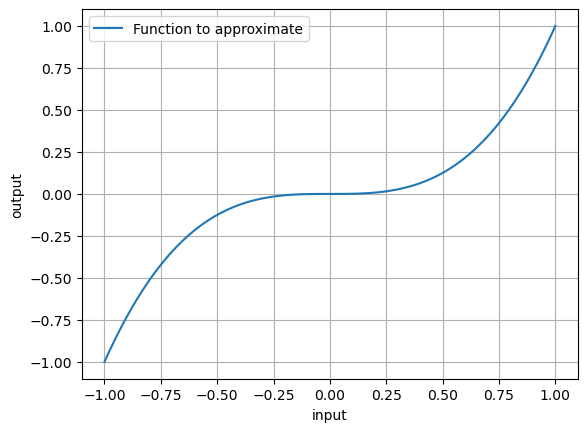

In [4]:
import numpy as np

# function that has to be learned by the network
def f(x, x_max, y_max, add_noise=True):
    y = y_max * (x/x_max)**3
    if(add_noise):
        y += 0.1*y_max*np.random.normal(size=x.shape)
    return y

x_grid = np.linspace(-1, 1, 100) 
plt.plot(x_grid, f(x_grid, 1, 1, False), label='Function to approximate')
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.legend()
plt.show()

Let's sample the function at random points to create two datasets:
* training set: it will be used for training the network
* test set: it will be used for checking that the network generalizes outside the training set

In [5]:
def create_datasets(x_max, y_max, TRAIN_SIZE, TEST_SIZE):
    inputs_train = np.random.uniform(-x_max, x_max, (TRAIN_SIZE,1))
    output_train = f(inputs_train, x_max, y_max)
    inputs_test = np.random.uniform(-x_max, x_max, (TEST_SIZE,1))
    output_test = f(inputs_test, x_max, y_max)
    
    inputs_train = torch.from_numpy(inputs_train).float()
    output_train = torch.from_numpy(output_train).float()
    inputs_test = torch.from_numpy(inputs_test).float()
    output_test = torch.from_numpy(output_test).float()
    
    return inputs_train, output_train, inputs_test, output_test

In [6]:
def plot_data(x_max, y_max, inputs_train, output_train, inputs_test, output_test):
    # generate 100 samples uniformly spaced between -x_max and x_max
    x_grid = np.linspace(-x_max, x_max, 100) 
    plt.plot(x_grid, f(x_grid, x_max, y_max, False), label='Real function')
    plt.plot(inputs_train, output_train, ' *', alpha=0.7, label='training set')
    plt.plot(inputs_test, output_test, ' v', alpha=0.7, label='test set')
    plt.xlabel('input')
    plt.ylabel('output')
    plt.grid(True)
    plt.legend()
    plt.show()

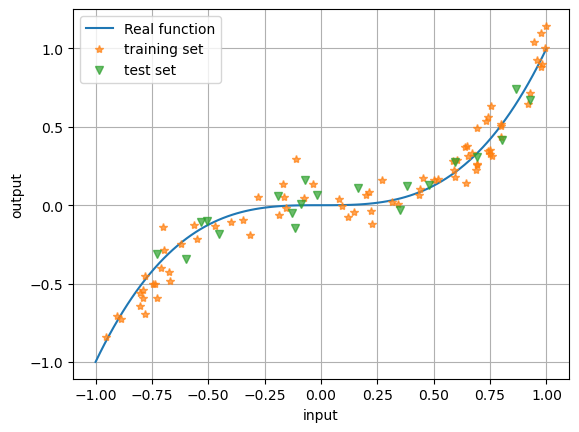

In [7]:
inputs_train, output_train, inputs_test, output_test = create_datasets(1, 1, TRAIN_SIZE=80, TEST_SIZE=20)
plot_data(1, 1, inputs_train, output_train, inputs_test, output_test)

Let's start training the network for a given number of epochs:
* At each epoch we perform a number of updates of the weights using mini-batches of a given size.
* The number of updates per epoch is computed so that all the training dataset could be seen in one epoch.
* At each epoch we store the loss on both training and test set
* We keep track of the weights corresponding to the minimum value of the loss on the test set

In [15]:
# Training loop
def train_network(net, optim, loss_func, in_train, out_train, in_test, out_test, epochs, b_size):
    # set the network in evaluation mode
    net.eval() 

    # list of values taken by the loss on the training/test set during training
    loss_train = loss_func(net(in_train), out_train).detach().numpy()
    losses_training = [loss_train] 
    loss_test = loss_func(net(in_test), out_test).detach().numpy()
    losses_test = [loss_test] 

    train_size = out_train.shape[0]
    iters_per_epoch = int(train_size/b_size) # number of iterations per epoch

    loss_min = loss_test # keep track of the minimum value taken by the loss on the test set
    weights_min = copy.deepcopy(net.state_dict())

    start = clock()
    for i in range(epochs):
        net.train() # set the network in training mode
#         if i % int(epochs/20) == 0:
#             print('Epoch: %d, log(training-loss) %.3f log(test-loss) %.3f' %(
#                 i, np.log10(losses_training[-1]), np.log10(losses_test[-1])))
        total_loss = 0
        for k in range(iters_per_epoch):
            # Compute the loss on a randomly sampled mini-batch
            ind = torch.randint(train_size, size=(b_size,1))
            loss = loss_func(net(in_train[ind]), out_train[ind])
            total_loss += loss.detach().numpy()
            # Backpropagation to compute the loss's gradient
            optim.zero_grad()
            loss.backward()
            # update the network's weights
            optim.step()

        losses_training.append(total_loss/iters_per_epoch)

        net.eval()  # Set the model in evaluation mode
        with torch.no_grad():  # Disable gradient computation
            loss_test = loss_func(net(in_test), out_test).detach().numpy()
        losses_test.append(loss_test)

        # keep track of the weights corresponding to the minimum loss
        if loss_test < loss_min:
            loss_min = loss_test
            weights_min = copy.deepcopy(net.state_dict())
    end = clock()
#     print("Elapsed time for the training: %.1f"%(end - start))
    return losses_training, losses_test, weights_min

In [9]:
# simple low-pass filter function for plotting less noisy version of loss
def low_pass_filter(data, alpha=0.1):
    filtered_data = len(data)*[data[0]]
    for i in range(1, len(data)):
        filtered_data[i] = (1-alpha)*filtered_data[i-1] + alpha*data[i]
    return filtered_data

In [10]:
def plot_results(net, w_best, losses_train, losses_test, x_max, y_max):
    x_grid = np.linspace(-x_max, x_max, 100)
    y_grid = f(x_grid, x_max, y_max, False)
    x_grid_torch = torch.from_numpy(x_grid).float().view(-1,1)
    filtered_loss_train = low_pass_filter(losses_train)
    filtered_loss_test  = low_pass_filter(losses_test)
    
    fig = plt.figure(figsize=(12,5))
    ax = fig.subplots(1,2)
    ax[0].plot(losses_train, alpha=0.5, label="train loss")
    ax[0].plot(losses_test, alpha=0.5, label="test loss")
    ax[0].plot(filtered_loss_train, linewidth=3, label="filtered train loss")
    ax[0].plot(filtered_loss_test, linewidth=3, label="filtered test loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_yscale("log")

    net.eval()
    ax[1].plot(x_grid, y_grid, '-', linewidth=5, alpha=0.8, label="Real function")
    ax[1].plot(x_grid, net(x_grid_torch).detach(), '--', linewidth=3, alpha=0.9, label='Network end of training')
    net.load_state_dict(w_best)
    ax[1].plot(x_grid, net(x_grid_torch).detach(), 'r-.', linewidth=3, alpha=0.9, label='Network best test loss')
    ax[1].set_xlabel('input')
    ax[1].set_ylabel('output')
    
    for i in range(2):
        ax[i].grid(True)
        ax[i].legend()
    plt.show()

In [13]:
from ipywidgets import interact, FloatSlider, fixed

def train_and_plot(log_learn_rate, log_x_max, log_y_max, TRAIN_SIZE, TEST_SIZE, epochs, batch_size):
    learning_rate = 10**log_learn_rate
    x_max, y_max = 10**log_x_max, 10**log_y_max
    net, optim, loss_func = create_network(learning_rate)
    in_train, out_train, in_test, out_test = create_datasets(x_max, y_max, TRAIN_SIZE, TEST_SIZE)
    losses_train, losses_test, w_best = train_network(net, optim, loss_func, in_train, out_train, 
                                                      in_test, out_test, epochs, batch_size)
    plot_results(net, w_best, losses_train, losses_test, x_max, y_max)

In [16]:
interact(train_and_plot, log_learn_rate=(-4,0), log_x_max=(-3, 3), log_y_max=(-3, 3), TRAIN_SIZE=fixed(20), 
         TEST_SIZE=fixed(200), epochs=(100, 1000, 100), batch_size=(5, 20, 5))

interactive(children=(IntSlider(value=-2, description='log_learn_rate', max=0, min=-4), IntSlider(value=0, des…

<function __main__.train_and_plot(log_learn_rate, log_x_max, log_y_max, TRAIN_SIZE, TEST_SIZE, epochs, batch_size)>

# Conclusions
* Setting the learning rate too large or too small can jeopardize learning
* Scaling inputs/outputs to be in [-1, 1] helps training accuracy
* Performance can worsen during training so keep track of best weights
* Beware of overfitting to training data by using test data